<a href="https://colab.research.google.com/github/Tannybuoy/Tannybuoy.github.io/blob/master/Testing_Top_P%2C_Top_K_algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Install dependencies (run once)
!pip install transformers torch accelerate -q



In [2]:
# Cell 2: Import libraries
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch



In [3]:
# Cell 3: Load model
print("Loading model...")
model_name = "gpt2"  # Small, fast model - good for learning
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
print("Model loaded!")



Loading model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded!


In [6]:
# Add this line to fix the warning
tokenizer.pad_token = tokenizer.eos_token


In [7]:
# Cell 4: Generate with top-k
def generate_text(prompt, top_k=50, temperature=0.7, max_tokens=50):
    """Generate text with top-k sampling"""
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    output = model.generate(
        input_ids,
        max_new_tokens=max_tokens,
        do_sample=True,
        top_k=top_k,
        temperature=temperature,
        pad_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(output[0], skip_special_tokens=True)



In [8]:
# Cell 5: Test it!
prompt = "The future of AI product management is"
result = generate_text(prompt, top_k=50, temperature=0.7)
print(result)



The future of AI product management is not so bright.

This is certainly true of most of the companies that are currently working on AI. Many of them are already well on their way to becoming big. While many of them are still under development, there are few that are likely


In [9]:
# Cell 6: Compare different top-k values
print("Comparing different top-k values:\n")

for k in [10, 30, 50, 100]:
    print(f"--- Top-k = {k} ---")
    result = generate_text(prompt, top_k=k, temperature=0.7, max_tokens=30)
    print(result)
    print()

Comparing different top-k values:

--- Top-k = 10 ---
The future of AI product management is in a very important and complex area. We are not going to go into it here. But for the sake of the future, we will focus on

--- Top-k = 30 ---
The future of AI product management is uncertain, but the new research from Stanford may provide a valuable resource in understanding the future of AI product management.

A study published in the journal

--- Top-k = 50 ---
The future of AI product management is very bright. It is a very bright future. If we don't get it right, we're going to be in a very difficult situation."


--- Top-k = 100 ---
The future of AI product management is going to be very difficult. We need to develop a robust platform and have an agile and scalable system to make these products better and smarter.





In [10]:
# Test the same prompt multiple times with the same top-k
# to see randomness

prompt = "The future of AI product management is"

print("Running top-k=50 five times:\n")
for i in range(5):
    result = generate_text(prompt, top_k=50, temperature=0.7, max_tokens=30)
    print(f"{i+1}. {result}\n")

Running top-k=50 five times:

1. The future of AI product management is in the field of artificial intelligence and automation. However, there are still many challenges to overcome and the world needs to take advantage of these opportunities.


2. The future of AI product management is also being explored:

- The future of AI product management is also being explored: New 'Discovery' technology that will allow companies like Google

3. The future of AI product management is very bright. The future of the AI product management industry is very bright.

To learn more about AI product management, you can read this post

4. The future of AI product management is quite bright," he says. "It is going to be about making software systems more intelligent and more capable, more adaptable, more accessible to the

5. The future of AI product management is going to be very different. It's going to be a lot more complex than we've ever seen before.

BENNETT: And



In [11]:
# Conservative: narrow choices, low randomness
generate_text(prompt, top_k=20, temperature=0.5)

# Balanced: medium choices, medium randomness
generate_text(prompt, top_k=50, temperature=0.7)

# Wild: wide choices, high randomness
generate_text(prompt, top_k=100, temperature=1.0)

'The future of AI product management is now in the hands of the IBM team, with the goal of developing the AI that they\'re using to solve their most complex problems."'

In [12]:
# Cell 7: Top-P Generation Function
def generate_with_top_p(prompt, top_p=0.9, temperature=0.7, max_tokens=50):
    """
    Generate text with top-p (nucleus) sampling

    Args:
        prompt: Input text
        top_p: Cumulative probability threshold (0.0 to 1.0)
               Higher = more diverse, Lower = more focused
        temperature: Randomness control
        max_tokens: Number of tokens to generate
    """
    encoded = tokenizer(prompt, return_tensors="pt")

    output = model.generate(
        encoded['input_ids'],
        attention_mask=encoded['attention_mask'],
        max_new_tokens=max_tokens,
        do_sample=True,
        top_p=top_p,              # 🔑 This is the key parameter!
        temperature=temperature,
        pad_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(output[0], skip_special_tokens=True)



In [13]:
# Cell 8: Test it
result = generate_with_top_p(
    "The future of AI product management is",
    top_p=0.9,
    temperature=0.7
)
print(result)



The future of AI product management is still unknown. For the time being, we'll keep you updated on our ongoing work with IBM, including its latest version of the IBM Watson AI.

Share this: Twitter

Facebook

LinkedIn

Google

Reddit




In [14]:
# Cell 9: Compare different top-p values
print("\n" + "="*60)
print("COMPARING DIFFERENT TOP-P VALUES")
print("="*60 + "\n")

prompt = "The future of AI product management is"

for p in [0.5, 0.7, 0.9, 0.95]:
    print(f"--- Top-p = {p} ---")
    result = generate_with_top_p(prompt, top_p=p, temperature=0.7, max_tokens=40)
    print(result)
    print()


COMPARING DIFFERENT TOP-P VALUES

--- Top-p = 0.5 ---
The future of AI product management is in the hands of the human.

The next big thing to happen is to get the software to be able to do a lot of things that humans can't. The next big thing to happen

--- Top-p = 0.7 ---
The future of AI product management is in the hands of an AI company that has a very strong track record of making good products.

The next step for the company is to get the best possible customer experience for its products. The

--- Top-p = 0.9 ---
The future of AI product management is an ever-changing market for software. For example, some of the most important things to be done with AI in the next decade are:

• The ability to identify and manage product-based

--- Top-p = 0.95 ---
The future of AI product management is in the hands of industry leaders, which is why we are thrilled to announce the first-ever version of the AI toolkit for the AI platform.

The toolkit contains several new features for



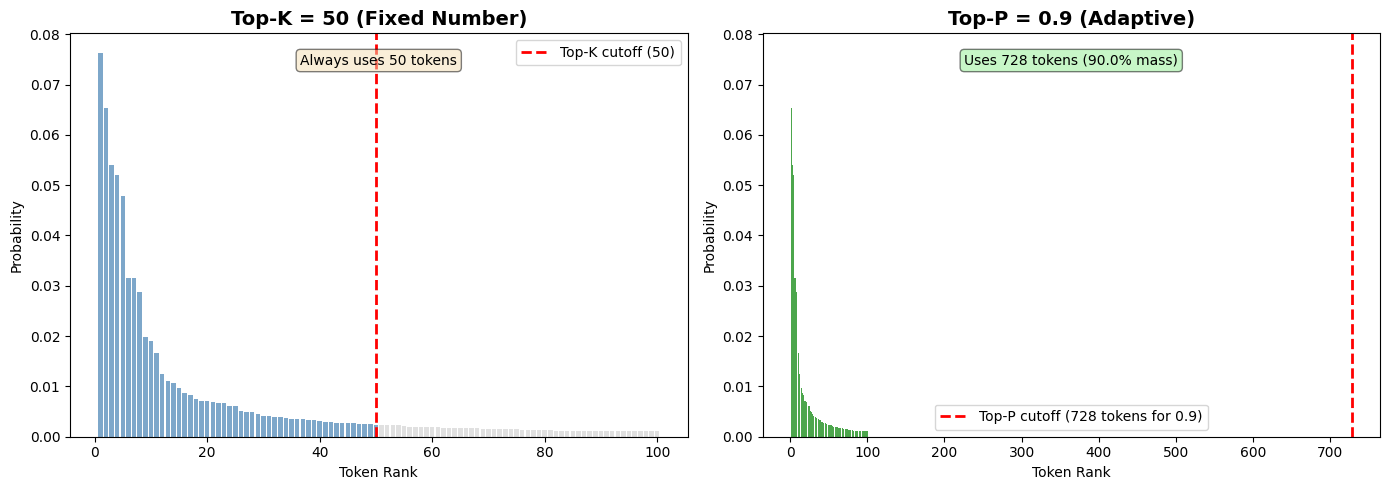


Prompt: 'The cat sat on the'

Top-K (50) would include tokens 1-50
Top-P (0.9) includes tokens 1-728 (reaching 90.0% probability)

Top 10 tokens:
1. ' floor' - 0.0764 | Top-K: ✓ | Top-P: ✓
2. ' bed' - 0.0653 | Top-K: ✓ | Top-P: ✓
3. ' couch' - 0.0541 | Top-K: ✓ | Top-P: ✓
4. ' ground' - 0.0521 | Top-K: ✓ | Top-P: ✓
5. ' edge' - 0.0478 | Top-K: ✓ | Top-P: ✓
6. ' bench' - 0.0316 | Top-K: ✓ | Top-P: ✓
7. ' table' - 0.0315 | Top-K: ✓ | Top-P: ✓
8. ' sofa' - 0.0288 | Top-K: ✓ | Top-P: ✓
9. ' other' - 0.0199 | Top-K: ✓ | Top-P: ✓
10. ' back' - 0.0190 | Top-K: ✓ | Top-P: ✓


In [15]:
# Cell 8: Visual Comparison
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_top_p_vs_top_k(prompt, top_k=50, top_p=0.9):
    """Visualize how top-k and top-p filter differently"""

    # Get probabilities
    encoded = tokenizer(prompt, return_tensors="pt")
    with torch.no_grad():
        outputs = model(encoded['input_ids'])
        logits = outputs.logits[0, -1, :]

    probs = torch.softmax(logits, dim=0).numpy()
    sorted_indices = np.argsort(probs)[::-1]
    sorted_probs = probs[sorted_indices]

    # Calculate cumulative for top-p
    cumsum = np.cumsum(sorted_probs)
    top_p_cutoff = np.searchsorted(cumsum, top_p) + 1

    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Top-K visualization
    x = range(1, 101)
    y = sorted_probs[:100]
    colors = ['steelblue' if i < top_k else 'lightgray' for i in range(100)]
    ax1.bar(x, y, color=colors, alpha=0.7)
    ax1.axvline(top_k, color='red', linestyle='--', linewidth=2, label=f'Top-K cutoff ({top_k})')
    ax1.set_title(f'Top-K = {top_k} (Fixed Number)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Token Rank')
    ax1.set_ylabel('Probability')
    ax1.legend()
    ax1.text(0.5, 0.95, f'Always uses {top_k} tokens',
             transform=ax1.transAxes, ha='center', va='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Top-P visualization
    colors_p = ['green' if i < top_p_cutoff else 'lightgray' for i in range(100)]
    ax2.bar(x, y, color=colors_p, alpha=0.7)
    ax2.axvline(top_p_cutoff, color='red', linestyle='--', linewidth=2,
                label=f'Top-P cutoff ({top_p_cutoff} tokens for {top_p})')
    ax2.set_title(f'Top-P = {top_p} (Adaptive)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Token Rank')
    ax2.set_ylabel('Probability')
    ax2.legend()
    ax2.text(0.5, 0.95, f'Uses {top_p_cutoff} tokens ({cumsum[top_p_cutoff-1]:.1%} mass)',
             transform=ax2.transAxes, ha='center', va='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

    plt.tight_layout()
    plt.show()

    # Show actual tokens
    print(f"\nPrompt: '{prompt}'\n")
    print(f"Top-K ({top_k}) would include tokens 1-{top_k}")
    print(f"Top-P ({top_p}) includes tokens 1-{top_p_cutoff} (reaching {cumsum[top_p_cutoff-1]:.1%} probability)\n")

    print("Top 10 tokens:")
    for i in range(10):
        token = tokenizer.decode([sorted_indices[i]])
        in_k = "✓" if i < top_k else "✗"
        in_p = "✓" if i < top_p_cutoff else "✗"
        print(f"{i+1}. '{token}' - {sorted_probs[i]:.4f} | Top-K: {in_k} | Top-P: {in_p}")

# Run visualization
visualize_top_p_vs_top_k("The cat sat on the", top_k=50, top_p=0.9)

In [16]:
# Cell 10: Interactive comparison tool
def compare_all_methods(prompt, num_samples=3):
    """Generate with different methods to see the differences"""

    print(f"Prompt: '{prompt}'\n")
    print("="*70)

    methods = [
        ("Greedy (no sampling)", {"do_sample": False}),
        ("Top-K only (k=50)", {"do_sample": True, "top_k": 50, "temperature": 0.7}),
        ("Top-P only (p=0.9)", {"do_sample": True, "top_p": 0.9, "temperature": 0.7}),
        ("Both (k=50, p=0.9)", {"do_sample": True, "top_k": 50, "top_p": 0.9, "temperature": 0.7}),
    ]

    for method_name, params in methods:
        print(f"\n📌 {method_name}")
        print("-" * 70)

        for i in range(num_samples):
            encoded = tokenizer(prompt, return_tensors="pt")
            output = model.generate(
                encoded['input_ids'],
                attention_mask=encoded['attention_mask'],
                max_new_tokens=30,
                pad_token_id=tokenizer.eos_token_id,
                **params
            )
            result = tokenizer.decode(output[0], skip_special_tokens=True)
            print(f"{i+1}. {result}")
        print()

# Run comparison
compare_all_methods("The hardest part of being a PM is", num_samples=2)

Prompt: 'The hardest part of being a PM is'


📌 Greedy (no sampling)
----------------------------------------------------------------------
1. The hardest part of being a PM is that you have to be able to do it. You have to be able to do it in a way that's not just a little bit of a
2. The hardest part of being a PM is that you have to be able to do it. You have to be able to do it in a way that's not just a little bit of a


📌 Top-K only (k=50)
----------------------------------------------------------------------
1. The hardest part of being a PM is that you don't feel well. You're not thinking about yourself or the people around you, you're thinking about what you think you're capable of
2. The hardest part of being a PM is being out of public view, but it's always a struggle to find a way to get out. The only way to get your message out is through


📌 Top-P only (p=0.9)
----------------------------------------------------------------------
1. The hardest part of being a PM is being

In [18]:
# Install JupyterLite
!pip install jupyterlite-core



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 6.8 MB/s eta 0:00:00
